In [8]:
#!pip install SpeechRecognition
#!pip install playsound
#!pip install gtts

### module import

In [9]:
import librosa
import librosa.display as dsp
import sklearn
import os
import speech_recognition as sr
import json
import pandas as pd
import numpy as np
import time
import playsound
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold,cross_val_score
from gtts import gTTS

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font',family='Malgun Gothic')

In [129]:
# 디지털 신호 추가 만들기
def train_dataset(folder_path, input_data):
    #folder_path = 'D:/project/data/sound'
    temp = []

    for idx, file in tqdm(input_data.iterrows(), colour='green'):
        abs_file_path= os.path.join(folder_path,file['file_name'])
        data, sr=librosa.load(abs_file_path, sr=16000)
        temp.append(data)
    input_data['data'] = temp
    print('Dataset 생성완료')
    return input_data[['file_name','data','sido']]

# 데이터 특징 추출
def preprocessing_train_dataset(data):
    mfccs=[]
    for i in data:
        extracted_features=librosa.feature.mfcc(y=i, sr=16000, n_mfcc=40)
        extracted_features=np.mean(extracted_features.T, axis=0)
        mfccs.append(extracted_features)
    return mfccs

# mel spectogram 추출
def preprocessing_mel_specto(data):
    mel_specto = []
    for i in data:
        extraced_mel_specto = librosa.feature.melspectrogram(y=i, sr=16000, n_mels=40)
        extraced_mel_specto = np.mean(extraced_mel_specto.T, axis=0)
        mel_specto.append(extraced_mel_specto)
    return mel_specto

# wav파일 데이터프레임으로 만들기
def wav_get_df(folder_path):
    f_data=[]
    for file in os.listdir(folder_path):
        if 'wav' in file:
            f_name=file
            text=str(f_name)
            sido=text[str(file).find('_' , str(file).find('_실내')-4)+1 : str(file).find('_실내')]
            f_data.append([f_name,sido])
    train=pd.DataFrame(f_data,columns=['file_name','sido'])
    return train

# 유클리드거리 Normalize 후 거리 계산
def dist_norm(v1,v2):
    import scipy as sp
    v1_normalized=v1/sp.linalg.norm(v1.toarray())
    v2_normalized=v2/sp.linalg.norm(v2.toarray())
    delta = v1_normalized - v2_normalized

    return sp.linalg.norm(delta.toarray())

# 형태소 분석 후 말뭉치 만들기
def word_tokens(sentence_list):
    from konlpy.tag import Okt
    t=Okt()
    new_word_tokens=[t.morphs(row) for row in sentence_list]
    new_word_vectorize=[]

    for content in new_word_tokens:
        sentence=''
        for word in content:
            sentence=sentence+' '+word
        new_word_vectorize.append(sentence)
    return new_word_vectorize

In [130]:
folder = 'D:/project/data/sound'
sido_dict = {'강원':0,'경상':1,'수도권':2,'전라':3,'제주':4,'충청':5}

train = wav_get_df(folder)
train.head()

,file_name,sido
0,노인남여_노인대화42_M_saheeae_61_수도권_실내_47250.wav,수도권
1,노인남여_노인대화42_M_saheeae_61_수도권_실내_47251.wav,수도권
2,노인남여_노인대화42_M_saheeae_61_수도권_실내_47252.wav,수도권
3,노인남여_노인대화42_M_saheeae_61_수도권_실내_47253.wav,수도권
4,노인남여_노인대화42_M_shzzang09_61_강원_실내_47250.wav,강원


In [131]:
# librosa data 붙이기
train = train_dataset(folder, train)

80it [00:00, 794.20it/s]

Dataset 생성완료


In [132]:
train.head(3)

,file_name,data,sido
0,노인남여_노인대화42_M_saheeae_61_수도권_실내_47250.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권
1,노인남여_노인대화42_M_saheeae_61_수도권_실내_47251.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권
2,노인남여_노인대화42_M_saheeae_61_수도권_실내_47252.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권


##### EDA

In [133]:
# labeling

for i in sido_dict:
    train.loc[train['sido']==i,'label']=sido_dict[i]
train=train.astype({'label':'int'})

In [134]:
train.head(3)

,file_name,data,sido,label
0,노인남여_노인대화42_M_saheeae_61_수도권_실내_47250.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2
1,노인남여_노인대화42_M_saheeae_61_수도권_실내_47251.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2
2,노인남여_노인대화42_M_saheeae_61_수도권_실내_47252.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2


In [135]:
# label값 순서
train['sido'].unique()

array(['수도권', '강원', '전라', '제주', '경상', '충청'], dtype=object)

In [136]:
train.head(3)

,file_name,data,sido,label
0,노인남여_노인대화42_M_saheeae_61_수도권_실내_47250.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2
1,노인남여_노인대화42_M_saheeae_61_수도권_실내_47251.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2
2,노인남여_노인대화42_M_saheeae_61_수도권_실내_47252.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2


##### 데이터 특징 추출

In [137]:
# train 셋을 MFCC알고리즘을 이용하여 특징 추출
mfccs=preprocessing_train_dataset(train.data)
mfccs=np.array(mfccs)
mfccs

array([[-3.1068497e+02,  3.2733238e+01,  3.2957138e+01, ...,
        -2.1848075e+00, -4.7321444e+00, -3.6186831e+00],
       [-3.2117139e+02,  3.5584671e+01,  3.1903616e+01, ...,
        -1.5928507e+00, -2.0415974e+00, -2.0641530e+00],
       [-3.6123444e+02,  7.3490593e+01,  9.7413788e+00, ...,
        -2.9921857e-01, -2.0832582e+00, -1.2986474e+00],
       ...,
       [-4.1085947e+02,  7.9185524e+01, -8.6800426e-01, ...,
         1.8426933e+00,  2.4194811e-01,  2.6584666e+00],
       [-4.3393106e+02,  8.0576927e+01,  5.5892811e+00, ...,
         5.4376240e+00,  2.7236152e+00,  2.5306194e+00],
       [-4.2421390e+02,  8.3980110e+01,  1.5271497e-01, ...,
         1.8065962e+00,  1.1356741e+00,  2.6321607e+00]], dtype=float32)

In [138]:
# mel specto
mel_spec = preprocessing_mel_specto(train.data)
mel_spec = np.array(mel_spec)
mel_spec

array([[6.84296727e-01, 1.39165103e+00, 5.29830647e+00, ...,
        4.50824648e-01, 6.39409721e-02, 7.33216200e-03],
       [2.57258356e-01, 1.46378016e+00, 3.37562895e+00, ...,
        7.03545332e-01, 9.34875160e-02, 7.23585254e-03],
       [5.55855334e-01, 2.63953257e+00, 2.95688272e+00, ...,
        1.94599573e-03, 8.79408151e-04, 4.51318745e-04],
       ...,
       [1.61691606e-02, 1.35398269e+00, 2.33877540e+00, ...,
        5.74776146e-04, 5.26546326e-04, 1.15853676e-04],
       [1.19632231e-02, 1.26473916e+00, 1.68106818e+00, ...,
        2.54975923e-04, 1.59971140e-04, 6.53692623e-05],
       [1.61725339e-02, 1.47489560e+00, 3.39081168e+00, ...,
        8.53458187e-05, 4.83987133e-05, 1.67688922e-05]], dtype=float32)

In [139]:
# 학습/검증 데이터 분리
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(mfccs, train.label, test_size=0.4, stratify=train.label)
mel_train_X, mel_test_X, mel_train_y, mel_test_y = train_test_split(mel_spec, train.label, test_size=0.4, stratify=train.label)

print('학습시킬 train 셋 :',train_X.shape, train_y.shape)
print('검증할 test 셋 :',test_X.shape, test_y.shape)

학습시킬 train 셋 : (48, 40) (48,)
검증할 test 셋 : (32, 40) (32,)


In [140]:
models=[]
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

In [141]:
data=[]
results=[]
mel_spec_data = []
mel_spec_results = []

for name, model in models:
    kfold=KFold(n_splits=5, random_state=13,shuffle=True)
    cv_results=cross_val_score(model, train_X, train_y,cv=kfold, scoring='accuracy')
    mel_cv_results = cross_val_score(model, mel_train_X, mel_train_y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    mel_spec_results.append(mel_cv_results)
    data.append([name,cv_results.mean(),cv_results.std()])
    mel_spec_data.append([name, mel_cv_results.mean(), mel_cv_results.std()])

    print('[mfcc]\t\t\t', name, cv_results.mean(), cv_results.std())
    print('[mel spectogram]\t', name, mel_cv_results.mean(), mel_cv_results.std())


[mfcc]			 RandomForestClassifier 0.7733333333333333 0.07048334012068314
[mel spectogram]	 RandomForestClassifier 0.6488888888888888 0.13673440055924585
[mfcc]			 DecisionTreeClassifier 0.5777777777777778 0.1928346057770368
[mel spectogram]	 DecisionTreeClassifier 0.5866666666666667 0.12057475525556033
[mfcc]			 AdaBoostClassifier 0.6022222222222222 0.08788319970348972
[mel spectogram]	 AdaBoostClassifier 0.29999999999999993 0.1977652929892177
[mfcc]			 GradientBoostingClassifier 0.7933333333333332 0.14012340240386176
[mel spectogram]	 GradientBoostingClassifier 0.5222222222222221 0.12938601447119677


In [142]:
result=pd.DataFrame(data,columns=['model','cv_mean','cv_std'])
result

,model,cv_mean,cv_std
0,RandomForestClassifier,0.773333,0.070483
1,DecisionTreeClassifier,0.577778,0.192835
2,AdaBoostClassifier,0.602222,0.087883
3,GradientBoostingClassifier,0.793333,0.140123


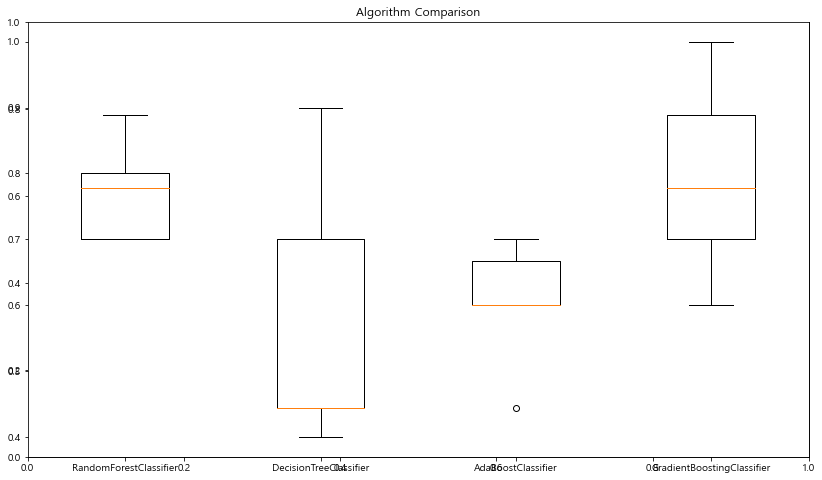

In [143]:
fig=plt.figure(figsize=(14,8))
plt.title('Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(result['model'])
plt.show()

In [144]:
def ACCURACY(true,pred):
    score=np.mean(true==pred)
    return score

In [145]:
for name,model in models:
    model.fit(train_X,train_y)
    pred=model.predict(test_X)
    score=ACCURACY(test_y,pred)
    print(f'모델의 정확도는 {score*100:.2f}% 입니다.')
    #result.loc[result['model']==name,'Accuracy Score']=score

모델의 정확도는 87.50% 입니다.
모델의 정확도는 68.75% 입니다.
모델의 정확도는 53.12% 입니다.
모델의 정확도는 68.75% 입니다.


In [108]:
result

,model,cv_mean,cv_std
0,RandomForestClassifier,0.828889,0.113224
1,DecisionTreeClassifier,0.686667,0.145619
2,AdaBoostClassifier,0.624444,0.103375
3,GradientBoostingClassifier,0.666667,0.073030


In [109]:
# 모델 성능확인
import numpy as np

def ACCURACY(true,pred):
    score=np.mean(true==pred)
    return score

prediction=model.predict(test_X)
score=ACCURACY(test_y,prediction)
print(f'모델의 정확도는 {score*100:.2f}% 입니다.')

모델의 정확도는 98.81% 입니다.


In [110]:
# test 데이터 평가결과
from sklearn.metrics import accuracy_score

for name, model in models:
    model.fit(train_X,train_y)
    pred=model.predict(test_X)
    print(name, accuracy_score(test_y,pred))

RandomForestClassifier 0.993807687813997
DecisionTreeClassifier 0.9059469564201426
AdaBoostClassifier 0.7968220586517116
GradientBoostingClassifier 0.9880827199439187


### 전체 테스트

In [146]:
# 전체 테스트
folder='D:/project/data/sound_merge'
test=wav_get_df(folder)
test.head()

,file_name,sido
0,노인남여_노인대화42_M_saheeae_61_수도권_실내_47250.wav,수도권
1,노인남여_노인대화42_M_saheeae_61_수도권_실내_47251.wav,수도권
2,노인남여_노인대화42_M_saheeae_61_수도권_실내_47252.wav,수도권
3,노인남여_노인대화42_M_saheeae_61_수도권_실내_47253.wav,수도권
4,노인남여_노인대화42_M_saheeae_61_수도권_실내_47254.wav,수도권


In [149]:
# librosa data 붙이기
folder='D:/project/data/sound_merge'
test = train_dataset(folder, test)
test.head()

21396it [01:24, 252.81it/s]

Dataset 생성완료


,file_name,data,sido
0,노인남여_노인대화42_M_saheeae_61_수도권_실내_47250.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권
1,노인남여_노인대화42_M_saheeae_61_수도권_실내_47251.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권
2,노인남여_노인대화42_M_saheeae_61_수도권_실내_47252.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권
3,노인남여_노인대화42_M_saheeae_61_수도권_실내_47253.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권
4,노인남여_노인대화42_M_saheeae_61_수도권_실내_47254.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권


In [151]:
for i in sido_dict:
    test.loc[test['sido']==i,'label']=sido_dict[i]
test=test.astype({'label':'int'})
test.head()

,file_name,data,sido,label
0,노인남여_노인대화42_M_saheeae_61_수도권_실내_47250.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2
1,노인남여_노인대화42_M_saheeae_61_수도권_실내_47251.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2
2,노인남여_노인대화42_M_saheeae_61_수도권_실내_47252.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2
3,노인남여_노인대화42_M_saheeae_61_수도권_실내_47253.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2
4,노인남여_노인대화42_M_saheeae_61_수도권_실내_47254.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",수도권,2


In [156]:
# test 셋을 MFCC알고리즘을 이용하여 특징 추출
mfccs_test = preprocessing_train_dataset(test.data)
mfccs_test = np.array(mfccs_test)
mfccs_test

array([[-3.1068497e+02,  3.2733238e+01,  3.2957138e+01, ...,
        -2.1848075e+00, -4.7321444e+00, -3.6186831e+00],
       [-3.2117139e+02,  3.5584671e+01,  3.1903616e+01, ...,
        -1.5928507e+00, -2.0415974e+00, -2.0641530e+00],
       [-3.6123444e+02,  7.3490593e+01,  9.7413788e+00, ...,
        -2.9921857e-01, -2.0832582e+00, -1.2986474e+00],
       ...,
       [-3.6308875e+02,  4.9525265e+01,  3.8788483e+01, ...,
         7.3604381e-01, -1.0305529e+00,  2.2937995e-01],
       [-3.7005289e+02,  5.5464611e+01,  3.1752571e+01, ...,
        -1.1063955e-02, -1.2999235e+00, -2.4740537e-01],
       [-3.6471500e+02,  5.2806866e+01,  2.9990681e+01, ...,
        -1.2403476e-01, -1.5416092e+00,  9.6639252e-01]], dtype=float32)

In [154]:
# test 셋을 mel specto 특징추출
mel_spec = preprocessing_mel_specto(test.data)
mel_spec = np.array(mel_spec)
mel_spec

array([[6.8429673e-01, 1.3916510e+00, 5.2983065e+00, ..., 4.5082465e-01,
        6.3940972e-02, 7.3321620e-03],
       [2.5725836e-01, 1.4637802e+00, 3.3756289e+00, ..., 7.0354533e-01,
        9.3487516e-02, 7.2358525e-03],
       [5.5585533e-01, 2.6395326e+00, 2.9568827e+00, ..., 1.9459957e-03,
        8.7940815e-04, 4.5131875e-04],
       ...,
       [2.0075577e-01, 5.5732894e+00, 6.8349667e+00, ..., 7.7857584e-02,
        2.4911073e-01, 5.5600435e-01],
       [1.3410009e-01, 4.7757845e+00, 1.6194263e+01, ..., 4.1049212e-02,
        1.3428156e-01, 1.9005243e-01],
       [9.9529363e-02, 4.8822556e+00, 8.6924171e+00, ..., 6.4965248e-02,
        2.3184368e-01, 3.1810084e-01]], dtype=float32)

In [158]:
# 이전 모델을 사용하여 predict

prediction_test = model.predict(mfccs_test)
score=ACCURACY(test.label ,prediction_test)
print(f'[mfcc] 모델의 정확도는 {score*100:.2f}% 입니다.')

prediction_test = model.predict(mel_spec)
print('=' * 40)
score=ACCURACY(test.label ,prediction_test)
print(f'[mel specto] 모델의 정확도는 {score*100:.2f}% 입니다.')

[mfcc] 모델의 정확도는 41.78% 입니다.
[mel specto] 모델의 정확도는 34.58% 입니다.


##### 함수 모음

In [57]:
# 대사 수집
label_path='D:/project/data/sound'
dir_list=os.listdir(label_path)
label_data=[]

for item in dir_list:
    temp=os.path.join(label_path,item)
    r=sr.Recognizer()
    if 'json' in item:
        with open(temp,'r', encoding='UTF-8') as f:
            json_data=json.load(f)
            label=json_data['발화정보']['stt'].replace('\r\n','')
        label_data.append(label)

In [58]:
len(label_data)

80

### CountVectorizer

In [59]:
vectorizer=CountVectorizer(min_df=1)
X=vectorizer.fit_transform(word_tokens(label_data))
num_samples, num_features=X.shape
X.toarray().transpose()
print(f'X에는 {num_samples}개의 문장에 말뭉치 단어가 총 {num_features}개 존재')

X에는 80개의 문장에 말뭉치 단어가 총 283개 존재


In [65]:
# 음성파일 데이터
path='D:/project/data/sound'
dir_list=os.listdir(path)
best_dist=[]
text_data=[]
best_dist_post=[]

for item in dir_list[:3]:

    if item[-3:] != 'wav':
        continue
    
    temp=os.path.join(path,item)
    r=sr.Recognizer()
    
    # STT
    with sr.AudioFile(temp) as source:
        audio=r.record(source, duration=120)
    new_post=r.recognize_google(audio_data=audio, language='ko-KR')
    new_post_list=[new_post]

    # 인풋 데이터 벡터화
    new_post_vec=vectorizer.transform(word_tokens(new_post_list))
    new_post_vec.toarray()
    
    # CountVector 정규화하여 거리 계산
    dist=[dist_norm(each, new_post_vec) for each in X]
    
    #유사도 측정
    best_dist.append(min(dist))
    text_data.append(new_post)
    best_dist_post.append(label_data[dist.index(min(dist))])

result2:
{   'alternative': [   {   'confidence': 0.76590234,
                           'transcript': '다시금 돼 찾을 수 있게 우리 오늘이 시간을 계기로 해서 해 '
                                         '보자고요'},
                       {'transcript': '다시금 돼 찾을 수 있게 우리 오늘 이시간을 계기로 해서 해 보자고요'},
                       {'transcript': '다시금 돼 찾을 수 있게 우리 오늘 2시간을 계기로 해서 해 보자고요'},
                       {'transcript': '다시금 돼 찾을 수 있게 우리 오늘이 시간을 계기로 해서 해 보자구요'},
                       {'transcript': '다시금대 찾을 수 있게 우리 오늘이 시간을 계기로 해서 해 보자고요'}],
    'final': True}


In [66]:
import pandas as pd
data={
    'Best_dist':best_dist,
    'Input_Data':text_data,
    'Best_Post':best_dist_post
}
test=pd.DataFrame(data)
test.head()

,Best_dist,Input_Data,Best_Post
0,0.485969,다시금 돼 찾을 수 있게 우리 오늘이 시간을 계기로 해서 해 보자고요,다시금 되찾을 수 있게 우리 오늘 이 시간을 계기로 해서 해 보자고요


In [67]:
for idx,row in test.iterrows():
    print('표준어 데이터 : ',row['Best_Post'])
    tts=gTTS(text=row['Best_Post'], lang='ko', slow=True)
    file_name=f"C:/Users/ej077/ds_study/source_code/ML_project/음성테스트{idx}.wav"
    tts.save(file_name)

    from IPython.display import Audio
    display(Audio(file_name, autoplay=True))

표준어 데이터 :  다시금 되찾을 수 있게 우리 오늘 이 시간을 계기로 해서 해 보자고요


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/ej077/ds_study/source_code/ML_project/음성테스트0.wav'

### TF-IDF

In [68]:
vectorizer=TfidfVectorizer(min_df=1, decode_error='ignore')
X=vectorizer.fit_transform(word_tokens(label_data))
num_samples, num_features=X.shape 
X.toarray().transpose() # 가중치와 역 가중치가 반영되면서 배열의 값이 바뀜
print(f'X에는 {num_samples}개의 문장에 말뭉치 단어가 총 {num_features}개 존재')

X에는 80개의 문장에 말뭉치 단어가 총 283개 존재


In [70]:
# 음성파일 데이터
path=r'D:/project/data/sound'
dir_list=os.listdir(path)
best_dist=[]
text_data=[]
best_dist_post=[]

for item in dir_list[:3]:

    if item[-3:] != 'wav':
        continue
    
    temp=os.path.join(path,item)
    r=sr.Recognizer()
    
    # STT
    with sr.AudioFile(temp) as source:
        audio=r.record(source, duration=120)
    new_post=r.recognize_google(audio_data=audio, language='ko-KR')
    new_post_list=[new_post]

    # 인풋 데이터 벡터화
    new_post_vec=vectorizer.transform(word_tokens(new_post_list))
    new_post_vec.toarray()
    
    # CountVector 정규화하여 거리 계산
    dist=[dist_norm(each, new_post_vec) for each in X]
    
    #유사도 측정
    best_dist.append(min(dist))
    text_data.append(new_post)
    best_dist_post.append(label_data[dist.index(min(dist))])

result2:
{   'alternative': [   {   'confidence': 0.76590228,
                           'transcript': '다시금 돼 찾을 수 있게 우리 오늘이 시간을 계기로 해서 해 '
                                         '보자고요'},
                       {'transcript': '다시금 돼 찾을 수 있게 우리 오늘 이시간을 계기로 해서 해 보자고요'},
                       {'transcript': '다시금 돼 찾을 수 있게 우리 오늘 2시간을 계기로 해서 해 보자고요'},
                       {'transcript': '다시금 돼 찾을 수 있게 우리 오늘이 시간을 계기로 해서 해 보자구요'},
                       {'transcript': '다시금대 찾을 수 있게 우리 오늘이 시간을 계기로 해서 해 보자고요'}],
    'final': True}


In [71]:
data={
    'Best_dist':best_dist,
    'Input_Data':text_data,
    'Best_Post':best_dist_post
}
test=pd.DataFrame(data)
test.head()

,Best_dist,Input_Data,Best_Post
0,0.529512,다시금 돼 찾을 수 있게 우리 오늘이 시간을 계기로 해서 해 보자고요,다시금 되찾을 수 있게 우리 오늘 이 시간을 계기로 해서 해 보자고요


In [87]:
for idx,row in test.iterrows():
    print('표준어 데이터 : ',row['Best_Post'])
    tts=gTTS(text=row['Best_Post'], lang='ko', slow=True)
    file_name=f"C:/Users/ej077/ds_study/source_code/ML_project/음성테스트{idx}.wav"
    tts.save(file_name)

    from IPython.display import Audio
    display(Audio(file_name, autoplay=True))

표준어 데이터 :  그러면 그게 발효가 돼서 가을에 김장할 때 파 있잖아


표준어 데이터 :  많이 남으면 거기 스티로폼 비닐 넣은 데에 파를 많이 심어놔요


표준어 데이터 :  그러면 봄까지 뽑아 먹으면 너무 좋더라고 그래서 저는 그렇게 먹어요
